In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

### Loading the dataset

In [3]:
spam_ham = pd.read_csv('spam.csv')[['Category', 'Message']]

In [4]:
spam_ham

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Encoding the Category column

In [5]:
# Label encoding spam as 1 and ham as 0
spam_ham['Category'] = spam_ham['Category'].map({'ham': 0, 'spam': 1})

In [6]:
spam_ham

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


### Cleaning the text for bettter classification

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # removing digits
    text = re.sub(r'[^\w\s]', '', text)  # removing punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # removing extra spaces
    return text

In [8]:
spam_ham['Message'] = spam_ham['Message'].apply(clean_text)
spam_ham.head(10)

,Category,Message
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup final ...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...
5,1,freemsg hey there darling its been weeks now a...
6,0,even my brother is not like to speak with me t...
7,0,as per your request melle melle oru minnaminun...
8,1,winner as a valued network customer you have b...
9,1,had your mobile months or more u r entitled to...


In [14]:
counts = spam_ham['Category'].value_counts()
labels = ['Ham', 'Spam']  # 0 = Ham, 1 = Spam

# Optional: if you encoded labels, map them back
if spam_ham['Category'].dtype != 'object':
    labels = ['Ham', 'Spam'] if counts.index[0] == 0 else ['Spam', 'Ham']

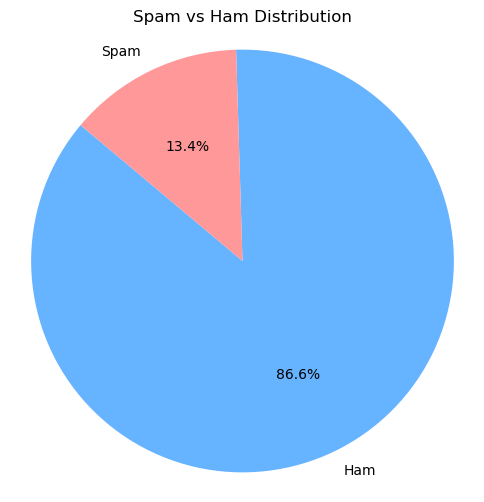

In [15]:
plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
plt.title("Spam vs Ham Distribution")
plt.axis('equal')  # Makes it a perfect circle
plt.show()

### Splitting the data 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(spam_ham['Message'], spam_ham['Category'],test_size=0.2, stratify=spam_ham['Category'],
                                                    random_state=42)

### Oversampling the spam category

In [11]:
train_df = pd.DataFrame({'Message': X_train, 'Category': y_train})
ham = train_df[train_df['Category'] == 0]
spam = train_df[train_df['Category'] == 1]
spam_oversampled = spam.sample(n=len(ham), replace=True, random_state=42)
balanced_train_df = pd.concat([ham, spam_oversampled]).sample(frac=1, random_state=42)

### Tokenization

In [12]:
max_words = 5000
max_len = 100 # it cover most of the text so that they are not truncated when padded

In [13]:
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_train_df['Message']) # initializing the tokenizer and fitting it on texts

In [14]:
X_train_seq = tokenizer.texts_to_sequences(balanced_train_df['Message'])
X_test_seq = tokenizer.texts_to_sequences(X_test) #tokenization to test data as well

In [15]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post') #padding for identical lengths

In [16]:
y_train = np.array(balanced_train_df['Category'])
y_test = np.array(y_test)

### Building the LSTM Model

In [17]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout
model = Sequential([Embedding(input_dim=max_words, output_dim=128, input_length=max_len),Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),Dropout(0.5),Dense(1, activation='sigmoid')])
#using bidirectional LSTM to cature the context better
#using LSTM as the patterns are remembered by LSTM
#using globalmaxpooling for taking the max values which has most effect

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
model.build(input_shape=(None, max_len))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 738,945 (2.82 MB)

 Trainable params: 738,945 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#using early stopping so that the model doesnt over fit
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train_pad, y_train,epochs=15,batch_size=32,validation_split=0.2,callbacks=[early_stop],verbose=1)

Epoch 1/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8309 - loss: 0.3945 - val_accuracy: 0.9877 - val_loss: 0.0432
Epoch 2/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9942 - loss: 0.0289 - val_accuracy: 0.9916 - val_loss: 0.0263
Epoch 3/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9969 - loss: 0.0116 - val_accuracy: 0.9987 - val_loss: 0.0042
Epoch 4/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9997 - loss: 0.0027 - val_accuracy: 0.9987 - val_loss: 0.0041
Epoch 5/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9987 - val_loss: 0.0085
Epoch 6/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9997 - loss: 7.8639e-04 - val_accuracy: 0.9987 - val_loss: 0.0086
Epoch 7/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 1.0000 - loss: 3.3146e-04 - val_accuracy: 0.9987 - val_loss: 0.0089


### Evaluate the model

In [20]:
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype('int32')

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


### Visualising the Results

              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       1.00      0.80      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



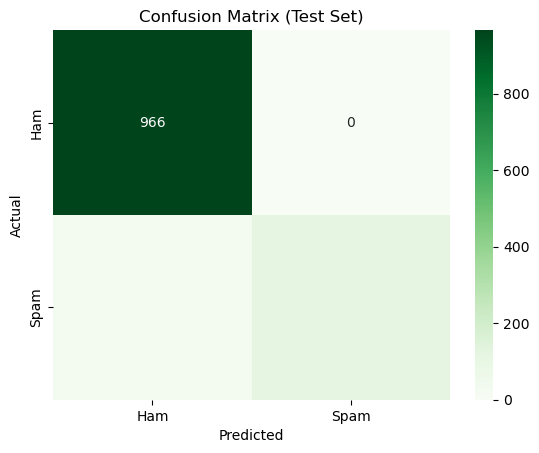

In [21]:
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

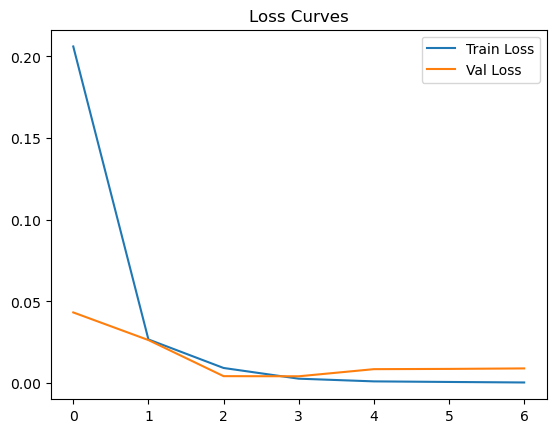

In [22]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

As validation loss flattens with train loss the model is not overfitting

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


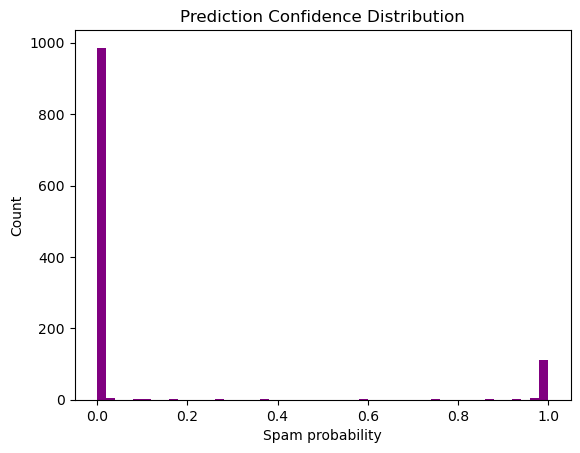

In [23]:
probs = model.predict(X_test_pad).ravel()
plt.hist(probs, bins=50, color='purple')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Spam probability')
plt.ylabel('Count')
plt.show()

As prediction confidence is either 0's or 1's the prediction is good & there is no leakage of data

In [24]:
#saving the model as .h5 as thats how a model is saved in neural networks
model.save("spam_lstm_model.h5")
#saving the tokenizer as same will be applied while testing
import pickle
with open("tokenizer_spam.pkl", "wb") as f:
    pickle.dump(tokenizer, f)